># 【問題1】仮定関数  
以下の数式で表される線形回帰の仮定関数を実装してください。メソッドの雛形を用意してあります。  

$
h_\theta(x) =  \theta_0 x_0 + \theta_1 x_1 + ... + \theta_j x_j + ... +\theta_n x_n.   (x_0 = 1)\\
$

x: 特徴量ベクトル

θ : パラメータベクトル

n : 特徴量の数


$x_j$: j番目の特徴量

$θ_j$: j番目のパラメータ（重み）

特徴量の数nは任意の値に対応できる実装にしてください。

なお、ベクトル形式で表すと以下のようになります。

$
h_\theta(x) = \theta^T \cdot x.
$


In [1242]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
warnings.simplefilter("ignore")

># 【問題2】最急降下法  
最急降下法により学習させる実装を行なってください。以下の式で表されるパラメータの更新式のメソッド_gradient_descentを追加し、fitメソッドから呼び出すようにしてください。

$
\theta_j := \theta_j - \alpha \frac{1}{m} \sum_{i=1}^{m}[(h_\theta(x^{(i)}) - y^{(i)} )x_{j}^{(i)}]
$

$α$:学習率

$i$:サンプルのインデックス

$j$:特徴量のインデックス

In [1239]:
class ScratchLinearRegression():
    """
    線形回帰のスクラッチ実装
    
    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue
    
    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録
    """
    
    def __init__(self, num_iter=5000, lr=1e-5, no_bias=False, verbose=True):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.no_bias = no_bias
        self.verbose = verbose
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
        
    def fit(self, X, y, X_val=np.empty(1), y_val=np.empty(1)):
        """
        線形回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        self.y = y[:,np.newaxis]  #_linear_hypothesisの返り値（行列）にサイズを合わせるためreshapeする
        self.y_val = y_val
        if self.no_bias == False:  #バイアス項がある時
            if X.ndim == 1:  #１次元の時(２次元であればここはスルー)
                X = X[:,np.newaxis]  #バイアス項と結合できるようにXを２次元に変形
            self.X = np.concatenate([np.ones(X.shape[0])[:,np.newaxis],X],axis=1)  #バイアス項を結合
            if(len(X_val) != 1) & (len(y_val) != 1): #検証データが入力された場合（入力されない場合は何もしない）
                if X_val.ndim == 1:  #検証データが１次元の時
                    X_val = X_val[:,np.newaxis]  #バイアス項と結合できるようにXを２次元に変形
                self.X_val = np.concatenate([np.ones(X_val.shape[0])[:,np.newaxis],X_val],axis=1)  #バイアス項を結合
        else:  #バイアス項がない時
            if X.ndim ==1:  #Xが１次元の時
                self.X = X[:,np.newaxis]
                self.X_val = X_val[:,np.newaxis]
            else:  #Xが２次元の時
                self.X = X
                self.X_val = X_val
        
        if (len(X_val) != 1) & (len(y_val) != 1):  #検証データが入力された場合
            error = self._gradient_descent(self.X)
            self.loss[0] = loss_func(self.predict(self.X),y)
            self.val_loss[0] = loss_func(self.predict(self.X_val),y_val)  #下に移動するべき
            for i in range(self.iter-1):  #iter-1回_gradient_descentを実行する
                error = self._gradient_descent(self.X,error)
                self.loss[i+1] = loss_func(self.predict(self.X),y)#(self.predict(self.X),y)
                self.val_loss[i+1] = loss_func(self.predict(self.X_val),self.y_val)  #下に移動するべき
                if self.verbose:
                    #verboseをTrueにした際は学習過程を出力
                    print("theta:{}".format(self.theta))
                    print("損失:{}".format(self.val_loss[i+1]))
                    print("精度（平均2乗誤差）:{}\n".format(MSE(self.predict(self.X_val),self.y_val)))
        else:  #検証データが入力されない場合
            error = self._gradient_descent(self.X)
            self.loss[0] =  loss_func(self.predict(self.X),y)
            for i in range(self.iter-1):
                error = self._gradient_descent(self.X,error)
                self.loss[i+1] = loss_func(self.predict(self.X),y)
                if self.verbose:
                    #verboseをTrueにした際は学習過程を出力
                    print("theta:\n{}".format(self.theta))
    
    def _gradient_descent(self, X,error=np.empty(1)):
        """
        θとXを用いて次のθを計算する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        
        error:次の形のndarray,shape (n_samples,)
            予測値と正解値の残差
        --------
        Returns
        --------
        次の形のndarray,shape(n_samples,)
        予測値と正解値の残差
        """
        if error.shape == (1,):  #errorが渡されていない時
            self.theta = np.ones(X.shape[1]).reshape(1,-1)#.reshape(1,X.shape[1])  #θを1で初期化
            error = (self._linear_hypothesis(X) - self.y).flatten()
        else:  #errorが渡されている時
            error = (self._linear_hypothesis(X) - self.y).flatten()
            error = (self._linear_hypothesis(X) - self.y).flatten()
        #次に使うθを計算
        self.theta = self.theta - (self.lr/X.shape[0])*error@X
        return error
    
    def _linear_hypothesis(self, X):
        """
        線形の仮定関数を計算する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
        訓練データ
        Returns
        -------
        次の形のndarray, shape (n_samples, 1)
        線形の仮定関数による推定結果
        """
        if X.ndim == 1:  #Xが１次元の時
            X = X[:,np.newaxis]  #２次元に変形
        if X.shape[1] != self.theta.T.shape[0]:
            #x_0が含まれていない状態でXを受け取った時（外部からのメソッド呼び出しを想定）
            X = np.concatenate([np.ones(X.shape[0])[:,np.newaxis],X],axis=1)
        return np.dot(X,self.theta.T)
    
    def predict(self, X):
        """
        線形回帰を使い推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            線形回帰による推定結果
        """
        return self._linear_hypothesis(X)

># 【問題3】推定
推定する仕組みを実装してください。ScratchLinearRegressionクラスの雛形に含まれるpredictメソッドに書き加えてください。  
仮定関数$h_\theta(x)$の出力が推定結果です。



上でクラスの中に定義

># 【問題4】平均二乗誤差  
線形回帰の指標値として用いられる平均二乗誤差（mean square error, MSE）の関数を作成してください。
平均二乗誤差関数は回帰問題全般で使える関数のため、ScratchLinearRegressionクラスのメソッドではなく、別の関数として作成してください。雛形を用意してあります。  
平均二乗誤差は以下の数式で表されます。 

>$
L(\theta)=  \frac{1 }{ m}  \sum_{i=1}^{m} (h_\theta(x^{(i)})-y^{(i)})^2.
$  

>$m$:入力されるデータの数  
$h_\theta()$:仮定関数  
$x^{(i)}$:i番目のサンプルの正解値  
$y^{(i)}$:i番目のサンプルの正解値  
なお、最急降下法のための目的関数（損失関数）としては、これを2で割ったものを使用します。（問題5, 9）

In [583]:
#平均2乗誤差
def MSE(y_pred,y):
    """
    平均二乗誤差の計算

    Parameters
    ----------
    y_pred : 次の形のndarray, shape (n_samples,)
      推定した値
    y : 次の形のndarray, shape (n_samples,)
      正解値

    Returns
    ----------
    mse : numpy.float
      平均二乗誤差
    """
    mse = ((y_pred - y)**2).mean()
    return mse

# 【問題5】目的関数
以下の数式で表される線形回帰の 目的関数（損失関数） を実装してください。そして、これをself.loss, self.val_lossに記録するようにしてください。  
目的関数（損失関数） $J(\theta)$ は次の式です。  

$
J(\theta)=  \frac{1 }{ 2m}  \sum_{i=1}^{m} (h_\theta(x^{(i)})-y^{(i)})^2.
$

$m$ : 入力されるデータの数


$h_\theta()$ : 仮定関数

$x^{(i)}$ : i番目のサンプルの特徴量ベクトル

$y^{(i)}$ : i番目のサンプルの正解値



In [544]:
#損失関数
def loss_func(y_pred,y):
    return MSE(y_pred,y)/2

# 【問題6】学習と推定
機械学習スクラッチ入門のSprintで用意したHouse Pricesコンペティションのデータに対してスクラッチ実装の学習と推定を行なってください。

scikit-learnによる実装と比べ、正しく動いているかを確認してください。



In [1219]:
df = pd.read_csv("../week3/train.csv")
#目的変数と相関関係の高い５つの特徴量
features_list = ["YearBuilt","GrLivArea"]
df_x = df[features_list]
df_y = df.SalePrice

尖度：6.536281860064529
歪度：1.8828757597682129


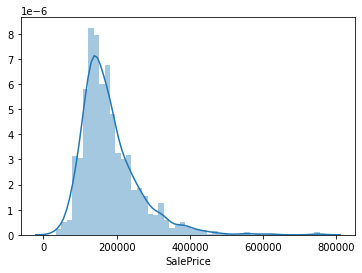

In [1220]:
print("尖度：{}".format(df_y.kurt()))
print("歪度：{}".format(df_y.skew()))
sns.distplot(df_y)
plt.show()

尖度：0.8095319958036296
歪度：0.12133506220520406


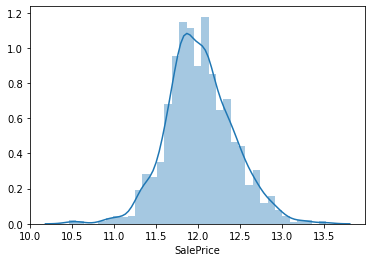

In [1221]:
#対数変換を行い、正規分布に近づける

df_x = df_x.apply(np.log)
df_y = df_y.apply(np.log)
print("尖度：{}".format(df_y.kurt()))
print("歪度：{}".format(df_y.skew()))
sns.distplot(df_y)
plt.show()

In [1222]:
x_train,x_test,y_train,y_test = \
train_test_split(np.array(df_x),np.array(df_y),train_size = 0.8,random_state=1)
lr = ScratchLinearRegression(verbose=False)
true_lr = LinearRegression()
lr.fit(x_train,y_train,x_test,y_test)
true_lr.fit(x_train,y_train)

LinearRegression()

In [1224]:
y_pred = lr.predict(x_test)
true_pred = true_lr.predict(x_test)
print("平均2乗誤差(スクラッチ):{}".format(MSE(y_pred,y_test)))
print("平均2乗誤差(scikit-learn):{}".format(mean_squared_error(true_pred,y_test)))

平均2乗誤差(スクラッチ):0.24084845167707664
平均2乗誤差(scikit-learn):0.0473970949071434


># 【問題7】学習曲線のプロット
学習曲線を表示する関数を作成し、実行してください。グラフを見て損失が適切に下がっているかどうか確認してください。  
線形回帰クラスの雛形ではself.loss, self.val_lossに損失を記録しておくようになっているため、入力にはこれを利用してください。

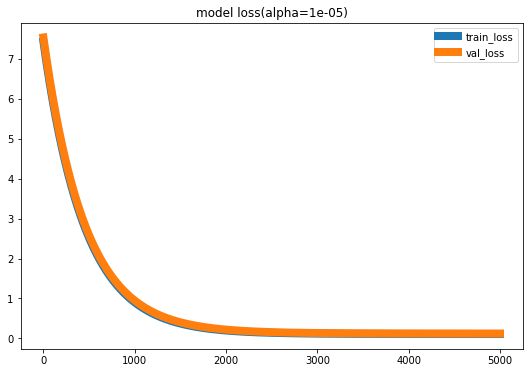

In [1225]:
fig,ax = plt.subplots(1,1,figsize=(9,6))
ax.set_title("model loss(alpha={})".format(lr.lr))
ax.plot(np.arange(len(lr.loss)),lr.loss,label="train_loss",linewidth=8)
ax.plot(np.arange(len(lr.val_loss)),lr.val_loss,label="val_loss",linewidth=8)
ax.legend()
plt.show()

># 【問題8】（アドバンス課題）バイアス項の除去
バイアス項 $\theta_0$ を抜くと学習がどう変化するか検証してください。また、線形回帰モデルにおけるバイアス項の役割の考察・調査を行ってください。

In [1226]:
lr2 = ScratchLinearRegression(no_bias=True,verbose=True)
lr2.fit(x_train,y_train,x_test,y_test,)

theta:[[0.9995716  0.99958898]]
損失:4.185994703741131
精度（平均2乗誤差）:8.371989407482262

theta:[[0.99935776 0.99938381]]
損失:4.177135433971585
精度（平均2乗誤差）:8.35427086794317

theta:[[0.99914416 0.99917887]]
損失:4.168295611045038
精度（平均2乗誤差）:8.336591222090076

theta:[[0.99893078 0.99897415]]
損失:4.159475192142391
精度（平均2乗誤差）:8.318950384284783

theta:[[0.99871765 0.99876966]]
損失:4.1506741345389635
精度（平均2乗誤差）:8.301348269077927

theta:[[0.99850475 0.99856539]]
損失:4.141892395604302
精度（平均2乗誤差）:8.283784791208603

theta:[[0.99829209 0.99836136]]
損失:4.133129932801957
精度（平均2乗誤差）:8.266259865603914

theta:[[0.99807966 0.99815754]]
損失:4.12438670368929
精度（平均2乗誤差）:8.24877340737858

theta:[[0.99786746 0.99795395]]
損失:4.115662665917258
精度（平均2乗誤差）:8.231325331834515

theta:[[0.9976555  0.99775059]]
損失:4.106957777230203
精度（平均2乗誤差）:8.213915554460407

theta:[[0.99744378 0.99754745]]
損失:4.098271995465659
精度（平均2乗誤差）:8.196543990931318

theta:[[0.99723229 0.99734454]]
損失:4.089605278554133
精度（平均2乗誤差）:8.179210557108266

theta:

theta:[[0.97054202 0.97173699]]
損失:3.0718147754331984
精度（平均2乗誤差）:6.143629550866397

theta:[[0.97036025 0.97156259]]
損失:3.0654000183296493
精度（平均2乗誤差）:6.1308000366592985

theta:[[0.97017868 0.97138839]]
損失:3.058999326950769
精度（平均2乗誤差）:6.117998653901538

theta:[[0.96999732 0.97121439]]
損失:3.052612670342799
精度（平均2乗誤差）:6.105225340685598

theta:[[0.96981615 0.97104057]]
損失:3.046240017620219
精度（平均2乗誤差）:6.092480035240438

theta:[[0.96963519 0.97086695]]
損失:3.0398813379656047
精度（平均2乗誤差）:6.079762675931209

theta:[[0.96945442 0.97069352]]
損失:3.0335366006294744
精度（平均2乗誤差）:6.067073201258949

theta:[[0.96927385 0.97052028]]
損失:3.0272057749301347
精度（平均2乗誤差）:6.054411549860269

theta:[[0.96909349 0.97034723]]
損失:3.0208888302535373
精度（平均2乗誤差）:6.0417776605070745

theta:[[0.96891332 0.97017437]]
損失:3.014585736053129
精度（平均2乗誤差）:6.029171472106258

theta:[[0.96873335 0.97000171]]
損失:3.0082964618496963
精度（平均2乗誤差）:6.016592923699393

theta:[[0.96855358 0.96982923]]
損失:3.002020977231222
精度（平均2乗誤差）:6.004041954462

theta:[[0.95299913 0.95490601]]
損失:2.484925232193569
精度（平均2乗誤差）:4.969850464387138

theta:[[0.95283675 0.95475021]]
損失:2.4797968402518995
精度（平均2乗誤差）:4.959593680503799

theta:[[0.95267455 0.95459459]]
損失:2.4746796837670924
精度（平均2乗誤差）:4.949359367534185

theta:[[0.95251252 0.95443914]]
損失:2.469573738024546
精度（平均2乗誤差）:4.939147476049092

theta:[[0.95235067 0.95428386]]
損失:2.4644789783641388
精度（平均2乗誤差）:4.9289579567282775

theta:[[0.952189   0.95412876]]
損失:2.4593953801801005
精度（平均2乗誤差）:4.918790760360201

theta:[[0.95202751 0.95397382]]
損失:2.454322918920901
精度（平均2乗誤差）:4.908645837841802

theta:[[0.9518662  0.95381906]]
損失:2.449261570089122
精度（平均2乗誤差）:4.898523140178244

theta:[[0.95170507 0.95366447]]
損失:2.4442113092413438
精度（平均2乗誤差）:4.8884226184826876

theta:[[0.95154412 0.95351004]]
損失:2.4391721119880225
精度（平均2乗誤差）:4.878344223976045

theta:[[0.95138334 0.95335579]]
損失:2.434143953993373
精度（平均2乗誤差）:4.868287907986746

theta:[[0.95122274 0.95320171]]
損失:2.429126810975249
精度（平均2乗誤差）:4.8582536219504

theta:[[0.9374722  0.94000938]]
損失:2.0197912407097025
精度（平均2乗誤差）:4.039582481419405

theta:[[0.93732697 0.93987005]]
損失:2.0156814290779232
精度（平均2乗誤差）:4.0313628581558465

theta:[[0.9371819  0.93973087]]
損失:2.0115806128377534
精度（平均2乗誤差）:4.023161225675507

theta:[[0.93703699 0.93959185]]
損失:2.007488772211559
精度（平均2乗誤差）:4.014977544423118

theta:[[0.93689224 0.93945298]]
損失:2.003405887465282
精度（平均2乗誤差）:4.006811774930564

theta:[[0.93674765 0.93931426]]
損失:1.9993319389083568
精度（平均2乗誤差）:3.9986638778167136

theta:[[0.93660323 0.9391757 ]]
損失:1.995266906893605
精度（平均2乗誤差）:3.99053381378721

theta:[[0.93645896 0.93903728]]
損失:1.9912107718171461
精度（平均2乗誤差）:3.9824215436342922

theta:[[0.93631485 0.93889903]]
損失:1.9871635141182997
精度（平均2乗誤差）:3.9743270282365994

theta:[[0.9361709  0.93876092]]
損失:1.9831251142794868
精度（平均2乗誤差）:3.9662502285589736

theta:[[0.93602711 0.93862297]]
損失:1.979095552826138
精度（平均2乗誤差）:3.958191105652276

theta:[[0.93588347 0.93848517]]
損失:1.9750748103266014
精度（平均2乗誤差）:3.950149620

theta:[[0.92345576 0.92656216]]
損失:1.6437073741921078
精度（平均2乗誤差）:3.2874147483842155

theta:[[0.92332601 0.92643769]]
損失:1.6404203095627339
精度（平均2乗誤差）:3.2808406191254678

theta:[[0.92319642 0.92631336]]
損失:1.6371404318571852
精度（平均2乗誤差）:3.2742808637143703

theta:[[0.92306696 0.92618916]]
損失:1.6338677252825473
精度（平均2乗誤差）:3.2677354505650946

theta:[[0.92293765 0.9260651 ]]
損失:1.6306021740807042
精度（平均2乗誤差）:3.2612043481614084

theta:[[0.92280848 0.92594118]]
損失:1.6273437625282525
精度（平均2乗誤差）:3.254687525056505

theta:[[0.92267945 0.92581739]]
損失:1.624092474936429
精度（平均2乗誤差）:3.248184949872858

theta:[[0.92255057 0.92569374]]
損失:1.620848295651033
精度（平均2乗誤差）:3.241696591302066

theta:[[0.92242182 0.92557023]]
損失:1.6176112090523536
精度（平均2乗誤差）:3.235222418104707

theta:[[0.92229322 0.92544685]]
損失:1.614381199555082
精度（平均2乗誤差）:3.228762399110164

theta:[[0.92216477 0.92532361]]
損失:1.6111582516082545
精度（平均2乗誤差）:3.222316503216509

theta:[[0.92203645 0.92520051]]
損失:1.6079423496951588
精度（平均2乗誤差）:3.2158846

theta:[[0.91093396 0.91454911]]
損失:1.3428766664349123
精度（平均2乗誤差）:2.6857533328698246

theta:[[0.91081806 0.91443792]]
損失:1.3402469801137482
精度（平均2乗誤差）:2.6804939602274964

theta:[[0.91070228 0.91432684]]
損失:1.3376230365683104
精度（平均2乗誤差）:2.6752460731366208

theta:[[0.91058663 0.91421589]]
損失:1.3350048231867666
精度（平均2乗誤差）:2.670009646373533

theta:[[0.9104711  0.91410506]]
損失:1.3323923273850597
精度（平均2乗誤差）:2.6647846547701195

theta:[[0.91035571 0.91399436]]
損失:1.329785536606849
精度（平均2乗誤差）:2.659571073213698

theta:[[0.91024044 0.91388377]]
損失:1.327184438323447
精度（平均2乗誤差）:2.654368876646894

theta:[[0.9101253  0.91377331]]
損失:1.324589020033757
精度（平均2乗誤差）:2.649178040067514

theta:[[0.91001028 0.91366297]]
損失:1.3219992692642184
精度（平均2乗誤差）:2.643998538528437

theta:[[0.9098954  0.91355275]]
損失:1.3194151735687367
精度（平均2乗誤差）:2.6388303471374734

theta:[[0.90978064 0.91344266]]
損失:1.3168367205286315
精度（平均2乗誤差）:2.633673441057263

theta:[[0.909666   0.91333268]]
損失:1.3142638977525698
精度（平均2乗誤差）:2.6285277

精度（平均2乗誤差）:2.2085726499598897

theta:[[0.89974742 0.90381729]]
損失:1.1021773583487249
精度（平均2乗誤差）:2.2043547166974498

theta:[[0.89964387 0.90371795]]
損失:1.1000729912872118
精度（平均2乗誤差）:2.2001459825744236

theta:[[0.89954044 0.90361872]]
損失:1.09797321370095
精度（平均2乗誤差）:2.1959464274019

theta:[[0.89943712 0.90351961]]
損失:1.0958780155177048
精度（平均2乗誤差）:2.1917560310354096

theta:[[0.89933392 0.9034206 ]]
損失:1.0937873866874201
精度（平均2乗誤差）:2.1875747733748403

theta:[[0.89923082 0.9033217 ]]
損失:1.0917013171821661
精度（平均2乗誤差）:2.1834026343643322

theta:[[0.89912785 0.90322291]]
損失:1.0896197969960897
精度（平均2乗誤差）:2.1792395939921794

theta:[[0.89902498 0.90312423]]
損失:1.087542816145365
精度（平均2乗誤差）:2.17508563229073

theta:[[0.89892223 0.90302566]]
損失:1.085470364668151
精度（平均2乗誤差）:2.170940729336302

theta:[[0.8988196  0.90292719]]
損失:1.083402432624532
精度（平均2乗誤差）:2.166804865249064

theta:[[0.89871708 0.90282884]]
損失:1.081339010096482
精度（平均2乗誤差）:2.162678020192964

theta:[[0.89861467 0.9027306 ]]
損失:1.07928008718

精度（平均2乗誤差）:1.8224427943471329

theta:[[0.88975373 0.89423006]]
損失:0.909533206452368
精度（平均2乗誤差）:1.819066412904736

theta:[[0.88966123 0.89414131]]
損失:0.9078486921694257
精度（平均2乗誤差）:1.8156973843388513

theta:[[0.88956882 0.89405267]]
損失:0.906167846262321
精度（平均2乗誤差）:1.812335692524642

theta:[[0.88947652 0.89396412]]
損失:0.9044906606863761
精度（平均2乗誤差）:1.8089813213727521

theta:[[0.88938432 0.89387567]]
損失:0.9028171274146208
精度（平均2乗誤差）:1.8056342548292417

theta:[[0.88929222 0.89378732]]
損失:0.9011472384377479
精度（平均2乗誤差）:1.8022944768754958

theta:[[0.88920023 0.89369907]]
損失:0.8994809857640784
精度（平均2乗誤差）:1.7989619715281568

theta:[[0.88910833 0.89361091]]
損失:0.89781836141952
精度（平均2乗誤差）:1.79563672283904

theta:[[0.88901654 0.89352286]]
損失:0.8961593574475306
精度（平均2乗誤差）:1.7923187148950612

theta:[[0.88892485 0.89343489]]
損失:0.8945039659090782
精度（平均2乗誤差）:1.7890079318181564

theta:[[0.88883326 0.89334703]]
損失:0.892852178882602
精度（平均2乗誤差）:1.785704357765204

theta:[[0.88874177 0.89325926]]
損失:0.8912039

theta:[[0.88099125 0.88582417]]
損失:0.7580059991370559
精度（平均2乗誤差）:1.5160119982741118

theta:[[0.88090842 0.88574472]]
損失:0.7566512173312284
精度（平均2乗誤差）:1.5133024346624568

theta:[[0.88082569 0.88566535]]
損失:0.7552993810836182
精度（平均2乗誤差）:1.5105987621672363

theta:[[0.88074305 0.88558607]]
損失:0.7539504839400044
精度（平均2乗誤差）:1.5079009678800088

theta:[[0.8806605  0.88550688]]
損失:0.752604519460368
精度（平均2乗誤差）:1.505209038920736

theta:[[0.88057804 0.88542778]]
損失:0.7512614812188546
精度（平均2乗誤差）:1.5025229624377092

theta:[[0.88049567 0.88534877]]
損失:0.7499213628037457
精度（平均2乗誤差）:1.4998427256074913

theta:[[0.88041339 0.88526984]]
損失:0.74858415781743
精度（平均2乗誤差）:1.49716831563486

theta:[[0.88033121 0.885191  ]]
損失:0.7472498598763663
精度（平均2乗誤差）:1.4944997197527325

theta:[[0.88024911 0.88511224]]
損失:0.7459184626110589
精度（平均2乗誤差）:1.4918369252221177

theta:[[0.88016711 0.88503358]]
損失:0.7445899596660217
精度（平均2乗誤差）:1.4891799193320434

theta:[[0.88008519 0.884955  ]]
損失:0.7432643446997517
精度（平均2乗誤差）:1.4865

theta:[[0.87329435 0.87844071]]
損失:0.6383051933544707
精度（平均2乗誤差）:1.2766103867089413

theta:[[0.87322003 0.87836942]]
損失:0.637210450353624
精度（平均2乗誤差）:1.274420900707248

theta:[[0.87314579 0.8782982 ]]
損失:0.6361180833619072
精度（平均2乗誤差）:1.2722361667238145

theta:[[0.87307163 0.87822707]]
損失:0.6350280871777664
精度（平均2乗誤差）:1.2700561743555328

theta:[[0.87299756 0.87815601]]
損失:0.633940456611086
精度（平均2乗誤差）:1.267880913222172

theta:[[0.87292356 0.87808503]]
損失:0.6328551864831601
精度（平均2乗誤差）:1.2657103729663202

theta:[[0.87284965 0.87801413]]
損失:0.631772271626673
精度（平均2乗誤差）:1.263544543253346

theta:[[0.87277582 0.87794331]]
損失:0.6306917068856686
精度（平均2乗誤差）:1.2613834137713371

theta:[[0.87270207 0.87787256]]
損失:0.6296134871155286
精度（平均2乗誤差）:1.2592269742310571

theta:[[0.87262841 0.8778019 ]]
損失:0.6285376071829486
精度（平均2乗誤差）:1.2570752143658972

theta:[[0.87255482 0.87773131]]
損失:0.6274640619659089
精度（平均2乗誤差）:1.2549281239318177

theta:[[0.87248132 0.8776608 ]]
損失:0.6263928463536527
精度（平均2乗誤差）:1.2527

theta:[[0.86612137 0.87156006]]
損失:0.5380337012840374
精度（平均2乗誤差）:1.0760674025680748

theta:[[0.86605497 0.87149637]]
損失:0.5371563791885557
精度（平均2乗誤差）:1.0743127583771115

theta:[[0.86598865 0.87143275]]
損失:0.5362809573569584
精度（平均2乗誤差）:1.0725619147139167

theta:[[0.8659224 0.8713692]]
損失:0.5354074316335313
精度（平均2乗誤差）:1.0708148632670627

theta:[[0.86585622 0.87130572]]
損失:0.534535797871694
精度（平均2乗誤差）:1.069071595743388

theta:[[0.86579012 0.87124231]]
損失:0.5336660519339792
精度（平均2乗誤差）:1.0673321038679584

theta:[[0.86572409 0.87117898]]
損失:0.5327981896920119
精度（平均2乗誤差）:1.0655963793840237

theta:[[0.86565813 0.87111571]]
損失:0.5319322070264899
精度（平均2乗誤差）:1.0638644140529798

theta:[[0.86559225 0.87105251]]
損失:0.5310680998271636
精度（平均2乗誤差）:1.0621361996543273

theta:[[0.86552644 0.87098938]]
損失:0.5302058639928177
精度（平均2乗誤差）:1.0604117279856353

theta:[[0.8654607  0.87092632]]
損失:0.5293454954312474
精度（平均2乗誤差）:1.0586909908624949

theta:[[0.86539503 0.87086333]]
損失:0.5284869900592419
精度（平均2乗誤差）:1.05

theta:[[0.8600108  0.86569872]]
損失:0.46119875855341635
精度（平均2乗誤差）:0.9223975171068327

theta:[[0.85995115 0.86564151]]
損失:0.4604876926716631
精度（平均2乗誤差）:0.9209753853433262

theta:[[0.85989157 0.86558436]]
損失:0.45977816365383184
精度（平均2乗誤差）:0.9195563273076637

theta:[[0.85983206 0.86552728]]
損失:0.4590701681426424
精度（平均2乗誤差）:0.9181403362852848

theta:[[0.85977261 0.86547025]]
損失:0.4583637027881907
精度（平均2乗誤差）:0.9167274055763814

theta:[[0.85971323 0.86541329]]
損失:0.4576587642479282
精度（平均2乗誤差）:0.9153175284958563

theta:[[0.85965391 0.8653564 ]]
損失:0.4569553491866501
精度（平均2乗誤差）:0.9139106983733002

theta:[[0.85959466 0.86529956]]
損失:0.4562534542764766
精度（平均2乗誤差）:0.9125069085529532

theta:[[0.85953547 0.86524279]]
損失:0.455553076196836
精度（平均2乗誤差）:0.911106152393672

theta:[[0.85947635 0.86518609]]
損失:0.45485421163445194
精度（平均2乗誤差）:0.9097084232689039

theta:[[0.8594173  0.86512944]]
損失:0.45415685728332317
精度（平均2乗誤差）:0.9083137145666463

theta:[[0.85935831 0.86507286]]
損失:0.45346100984471216
精度（平均2乗誤

精度（平均2乗誤差）:0.7920800216396634

theta:[[0.85420091 0.86012603]]
損失:0.39546961171318823
精度（平均2乗誤差）:0.7909392234263765

theta:[[0.85414769 0.86007498]]
損失:0.39490044236936517
精度（平均2乗誤差）:0.7898008847387303

theta:[[0.85409452 0.86002398]]
損失:0.39433250010541354
精度（平均2乗誤差）:0.7886650002108271

theta:[[0.85404141 0.85997304]]
損失:0.3937657822442736
精度（平均2乗誤差）:0.7875315644885472

theta:[[0.85398836 0.85992216]]
損失:0.3932002861147607
精度（平均2乗誤差）:0.7864005722295214

theta:[[0.85393537 0.85987133]]
損失:0.39263600905155466
精度（平均2乗誤差）:0.7852720181031093

theta:[[0.85388243 0.85982056]]
損失:0.392072948395186
精度（平均2乗誤差）:0.784145896790372

theta:[[0.85382956 0.85976984]]
損失:0.3915111014920204
精度（平均2乗誤差）:0.7830222029840408

theta:[[0.85377674 0.85971918]]
損失:0.3909504656942501
精度（平均2乗誤差）:0.7819009313885003

theta:[[0.85372398 0.85966858]]
損失:0.3903910383598785
精度（平均2乗誤差）:0.780782076719757

theta:[[0.85367128 0.85961803]]
損失:0.3898328168527091
精度（平均2乗誤差）:0.7796656337054182

theta:[[0.85361864 0.85956754]]
損

theta:[[0.84911139 0.85524451]]
損失:0.3437571315171078
精度（平均2乗誤差）:0.6875142630342156

theta:[[0.84906379 0.85519886]]
損失:0.34329930670712655
精度（平均2乗誤差）:0.6865986134142531

theta:[[0.84901623 0.85515325]]
損失:0.3428424662241206
精度（平均2乗誤差）:0.6856849324482412

theta:[[0.84896874 0.85510769]]
損失:0.3423866079236936
精度（平均2乗誤差）:0.6847732158473872

theta:[[0.84892129 0.85506218]]
損失:0.3419317296661522
精度（平均2乗誤差）:0.6838634593323044

theta:[[0.84887389 0.85501673]]
損失:0.3414778293164958
精度（平均2乗誤差）:0.6829556586329916

theta:[[0.84882655 0.85497132]]
損失:0.3410249047444078
精度（平均2乗誤差）:0.6820498094888156

theta:[[0.84877926 0.85492597]]
損失:0.3405729538242441
精度（平均2乗誤差）:0.6811459076484881

theta:[[0.84873202 0.85488066]]
損失:0.3401219744350215
精度（平均2乗誤差）:0.680243948870043

theta:[[0.84868484 0.85483541]]
損失:0.33967196446040976
精度（平均2乗誤差）:0.6793439289208195

theta:[[0.84863771 0.8547902 ]]
損失:0.33922292178872065
精度（平均2乗誤差）:0.6784458435774413

theta:[[0.84859062 0.85474504]]
損失:0.3387748443128965
精度（平均2乗誤差

theta:[[0.84451692 0.85083803]]
損失:0.3017802318349396
精度（平均2乗誤差）:0.6035604636698793

theta:[[0.84447439 0.85079725]]
損失:0.301412528028618
精度（平均2乗誤差）:0.602825056057236

theta:[[0.8444319 0.8507565]]
損失:0.3010456123641738
精度（平均2乗誤差）:0.6020912247283476

theta:[[0.84438947 0.85071581]]
損失:0.3006794831273602
精度（平均2乗誤差）:0.6013589662547204

theta:[[0.84434708 0.85067515]]
損失:0.30031413860768663
精度（平均2乗誤差）:0.6006282772153733

theta:[[0.84430474 0.85063455]]
損失:0.29994957709841175
精度（平均2乗誤差）:0.5998991541968235

theta:[[0.84426245 0.85059398]]
損失:0.29958579689653425
精度（平均2乗誤差）:0.5991715937930685

theta:[[0.8442202  0.85055347]]
損失:0.29922279630278575
精度（平均2乗誤差）:0.5984455926055715

theta:[[0.844178   0.85051299]]
損失:0.2988605736216209
精度（平均2乗誤差）:0.5977211472432418

theta:[[0.84413584 0.85047256]]
損失:0.2984991271612114
精度（平均2乗誤差）:0.5969982543224228

theta:[[0.84409373 0.85043218]]
損失:0.29813845523343546
精度（平均2乗誤差）:0.5962769104668709

theta:[[0.84405167 0.85039184]]
損失:0.2977785561538713
精度（平均2乗誤差）

theta:[[0.8404123  0.84690159]]
損失:0.26805512702072726
精度（平均2乗誤差）:0.5361102540414545

theta:[[0.8403743  0.84686515]]
損失:0.2677595950092605
精度（平均2乗誤差）:0.535519190018521

theta:[[0.84033635 0.84682876]]
損失:0.2674646942935714
精度（平均2乗誤差）:0.5349293885871428

theta:[[0.84029844 0.8467924 ]]
損失:0.26717042350301157
精度（平均2乗誤差）:0.5343408470060231

theta:[[0.84026057 0.84675609]]
損失:0.26687678126993364
精度（平均2乗誤差）:0.5337535625398673

theta:[[0.84022274 0.84671981]]
損失:0.26658376622968505
精度（平均2乗誤差）:0.5331675324593701

theta:[[0.84018496 0.84668357]]
損失:0.2662913770206011
精度（平均2乗誤差）:0.5325827540412023

theta:[[0.84014721 0.84664738]]
損失:0.26599961228399815
精度（平均2乗誤差）:0.5319992245679963

theta:[[0.84010951 0.84661122]]
損失:0.2657084706641684
精度（平均2乗誤差）:0.5314169413283368

theta:[[0.84007185 0.84657511]]
損失:0.26541795080837166
精度（平均2乗誤差）:0.5308359016167433

theta:[[0.84003423 0.84653903]]
損失:0.26512805136682976
精度（平均2乗誤差）:0.5302561027336595

theta:[[0.83999666 0.84650299]]
損失:0.2648387709927198
精度（平均

theta:[[0.83677928 0.84341764]]
損失:0.2411777677087801
精度（平均2乗誤差）:0.4823555354175602

theta:[[0.8367453  0.84338506]]
損失:0.24093954910914356
精度（平均2乗誤差）:0.4818790982182871

theta:[[0.83671135 0.84335251]]
損失:0.24070183748282828
精度（平均2乗誤差）:0.48140367496565656

theta:[[0.83667745 0.84332   ]]
損失:0.24046463173127425
精度（平均2乗誤差）:0.4809292634625485

theta:[[0.83664358 0.84328752]]
損失:0.24022793075832405
精度（平均2乗誤差）:0.4804558615166481

theta:[[0.83660975 0.84325508]]
損失:0.239991733470219
精度（平均2乗誤差）:0.479983466940438

theta:[[0.83657595 0.84322267]]
損失:0.23975603877559207
精度（平均2乗誤差）:0.47951207755118413

theta:[[0.83654219 0.8431903 ]]
損失:0.23952084558546352
精度（平均2乗誤差）:0.47904169117092704

theta:[[0.83650848 0.84315796]]
損失:0.2392861528132357
精度（平均2乗誤差）:0.4785723056264714

theta:[[0.83647479 0.84312567]]
損失:0.23905195937468743
精度（平均2乗誤差）:0.47810391874937486

theta:[[0.83644115 0.8430934 ]]
損失:0.23881826418796953
精度（平均2乗誤差）:0.47763652837593906

theta:[[0.83640754 0.84306117]]
損失:0.2385850661735982


精度（平均2乗誤差）:0.438624108646942

theta:[[0.83346924 0.84024366]]
損失:0.21912027940330545
精度（平均2乗誤差）:0.4382405588066109

theta:[[0.83343892 0.84021458]]
損失:0.21892891092163788
精度（平均2乗誤差）:0.43785782184327576

theta:[[0.83340863 0.84018553]]
損失:0.21873794799970026
精度（平均2乗誤差）:0.4374758959994005

theta:[[0.83337837 0.84015652]]
損失:0.2185473897606447
精度（平均2乗誤差）:0.4370947795212894

theta:[[0.83334814 0.84012754]]
損失:0.21835723532953916
精度（平均2乗誤差）:0.4367144706590783

theta:[[0.83331795 0.84009859]]
損失:0.21816748383336285
精度（平均2乗誤差）:0.4363349676667257

theta:[[0.8332878  0.84006967]]
損失:0.21797813440100303
精度（平均2乗誤差）:0.43595626880200605

theta:[[0.83325767 0.84004079]]
損失:0.2177891861632499
精度（平均2乗誤差）:0.4355783723264998

theta:[[0.83322758 0.84001194]]
損失:0.21760063825279177
精度（平均2乗誤差）:0.43520127650558355

theta:[[0.83319752 0.83998311]]
損失:0.2174124898042134
精度（平均2乗誤差）:0.4348249796084268

theta:[[0.8331675  0.83995432]]
損失:0.2172247399539893
精度（平均2乗誤差）:0.4344494799079786

theta:[[0.8331375  0.8399

theta:[[0.83056957 0.83746338]]
損失:0.2017015128348196
精度（平均2乗誤差）:0.4034030256696392

theta:[[0.83054245 0.83743738]]
損失:0.20154698059922893
精度（平均2乗誤差）:0.40309396119845786

theta:[[0.83051536 0.83741141]]
損失:0.20139277437149616
精度（平均2乗誤差）:0.4027855487429923

theta:[[0.83048829 0.83738546]]
損失:0.20123889344848178
精度（平均2乗誤差）:0.40247778689696356

theta:[[0.83046126 0.83735954]]
損失:0.2010853371285811
精度（平均2乗誤差）:0.4021706742571622

theta:[[0.83043426 0.83733365]]
損失:0.20093210471171996
精度（平均2乗誤差）:0.4018642094234399

theta:[[0.83040729 0.83730779]]
損失:0.20077919549935244
精度（平均2乗誤差）:0.4015583909987049

theta:[[0.83038034 0.83728196]]
損失:0.20062660879445604
精度（平均2乗誤差）:0.4012532175889121

theta:[[0.83035343 0.83725615]]
損失:0.20047434390152982
精度（平均2乗誤差）:0.40094868780305964

theta:[[0.83032655 0.83723038]]
損失:0.20032240012659022
精度（平均2乗誤差）:0.40064480025318044

theta:[[0.83029969 0.83720463]]
損失:0.2001707767771679
精度（平均2乗誤差）:0.4003415535543358

theta:[[0.83027287 0.83717891]]
損失:0.2000194731623041

theta:[[0.82797615 0.83497698]]
損失:0.18762892548724056
精度（平均2乗誤差）:0.3752578509744811

theta:[[0.82795189 0.83495372]]
損失:0.18750401170468203
精度（平均2乗誤差）:0.37500802340936407

theta:[[0.82792766 0.83493049]]
損失:0.18737936012904
精度（平均2乗誤差）:0.37475872025808

theta:[[0.82790346 0.83490729]]
損失:0.18725497019630546
精度（平均2乗誤差）:0.37450994039261093

theta:[[0.82787928 0.83488411]]
損失:0.18713084134369878
精度（平均2乗誤差）:0.37426168268739757

theta:[[0.82785513 0.83486095]]
損失:0.1870069730096668
精度（平均2乗誤差）:0.3740139460193336

theta:[[0.82783101 0.83483783]]
損失:0.18688336463387925
精度（平均2乗誤差）:0.3737667292677585

theta:[[0.82780691 0.83481473]]
損失:0.18676001565722794
精度（平均2乗誤差）:0.3735200313144559

theta:[[0.82778284 0.83479165]]
損失:0.18663692552182157
精度（平均2乗誤差）:0.37327385104364313

theta:[[0.82775879 0.8347686 ]]
損失:0.1865140936709858
精度（平均2乗誤差）:0.3730281873419716

theta:[[0.82773478 0.83474557]]
損失:0.1863915195492583
精度（平均2乗誤差）:0.3727830390985166

theta:[[0.82771079 0.83472257]]
損失:0.18626920260238738
精度（

theta:[[0.82565663 0.83275338]]
損失:0.17624759804493156
精度（平均2乗誤差）:0.3524951960898631

theta:[[0.82563493 0.83273258]]
損失:0.17614651317822666
精度（平均2乗誤差）:0.3522930263564533

theta:[[0.82561326 0.83271181]]
損失:0.1760456393340092
精度（平均2乗誤差）:0.3520912786680184

theta:[[0.82559161 0.83269106]]
損失:0.17594497605972367
精度（平均2乗誤差）:0.35188995211944735

theta:[[0.82556999 0.83267033]]
損失:0.17584452290379884
精度（平均2乗誤差）:0.3516890458075977

theta:[[0.82554839 0.83264963]]
損失:0.17574427941564635
精度（平均2乗誤差）:0.3514885588312927

theta:[[0.82552681 0.83262894]]
損失:0.17564424514565782
精度（平均2乗誤差）:0.35128849029131565

theta:[[0.82550526 0.83260828]]
損失:0.17554441964520304
精度（平均2乗誤差）:0.3510888392904061

theta:[[0.82548373 0.83258765]]
損失:0.17544480246662822
精度（平均2乗誤差）:0.35088960493325644

theta:[[0.82546223 0.83256703]]
損失:0.17534539316325282
精度（平均2乗誤差）:0.35069078632650563

theta:[[0.82544075 0.83254644]]
損失:0.17524619128936839
精度（平均2乗誤差）:0.35049238257873677

theta:[[0.82541929 0.83252587]]
損失:0.1751471964002

theta:[[0.82358207 0.83076484]]
損失:0.16703212666762643
精度（平均2乗誤差）:0.33406425333525286

theta:[[0.82356266 0.83074624]]
損失:0.1669502253034125
精度（平均2乗誤差）:0.333900450606825

theta:[[0.82354328 0.83072766]]
損失:0.16686849388478503
精度（平均2乗誤差）:0.33373698776957006

theta:[[0.82352392 0.8307091 ]]
損失:0.16678693204848558
精度（平均2乗誤差）:0.33357386409697115

theta:[[0.82350458 0.83069056]]
損失:0.16670553943204522
精度（平均2乗誤差）:0.33341107886409044

theta:[[0.82348526 0.83067205]]
損失:0.16662431567378155
精度（平均2乗誤差）:0.3332486313475631

theta:[[0.82346596 0.83065355]]
損失:0.16654326041279793
精度（平均2乗誤差）:0.33308652082559587

theta:[[0.82344669 0.83063508]]
損失:0.16646237328898195
精度（平均2乗誤差）:0.3329247465779639

theta:[[0.82342743 0.83061662]]
損失:0.16638165394300242
精度（平均2乗誤差）:0.33276330788600483

theta:[[0.8234082  0.83059818]]
損失:0.1663011020163093
精度（平均2乗誤差）:0.3326022040326186

theta:[[0.82338898 0.83057977]]
損失:0.16622071715113074
精度（平均2乗誤差）:0.3324414343022615

theta:[[0.82336979 0.83056138]]
損失:0.16614049899047

theta:[[0.82174396 0.82900316]]
損失:0.15962745004359657
精度（平均2乗誤差）:0.31925490008719315

theta:[[0.82172658 0.8289865 ]]
損失:0.15956086618571924
精度（平均2乗誤差）:0.3191217323714385

theta:[[0.82170923 0.82896987]]
損失:0.15949441958785926
精度（平均2乗誤差）:0.3189888391757185

theta:[[0.82169189 0.82895326]]
損失:0.15942810995768467
精度（平均2乗誤差）:0.31885621991536933

theta:[[0.82167458 0.82893666]]
損失:0.15936193700349713
精度（平均2乗誤差）:0.31872387400699426

theta:[[0.82165728 0.82892008]]
損失:0.15929590043423067
精度（平均2乗誤差）:0.31859180086846134

theta:[[0.82164    0.82890352]]
損失:0.15922999995945028
精度（平均2乗誤差）:0.31845999991890056

theta:[[0.82162274 0.82888698]]
損失:0.15916423528935073
精度（平均2乗誤差）:0.31832847057870145

theta:[[0.8216055  0.82887046]]
損失:0.15909860613475466
精度（平均2乗誤差）:0.3181972122695093

theta:[[0.82158828 0.82885396]]
損失:0.1590331122071118
精度（平均2乗誤差）:0.3180662244142236

theta:[[0.82157107 0.82883747]]
損失:0.15896775321849682
精度（平均2乗誤差）:0.31793550643699364

theta:[[0.82155389 0.828821  ]]
損失:0.15890252888

theta:[[0.82006703 0.82739618]]
損失:0.15349531097197833
精度（平均2乗誤差）:0.30699062194395665

theta:[[0.82005151 0.8273813 ]]
損失:0.1534413249943171
精度（平均2乗誤差）:0.3068826499886342

theta:[[0.820036   0.82736644]]
損失:0.15338744949738464
精度（平均2乗誤差）:0.3067748989947693

theta:[[0.82002051 0.8273516 ]]
損失:0.15333368424684093
精度（平均2乗誤差）:0.30666736849368187

theta:[[0.82000504 0.82733678]]
損失:0.15328002900885349
精度（平均2乗誤差）:0.30656005801770697

theta:[[0.81998959 0.82732197]]
損失:0.15322648355009505
精度（平均2乗誤差）:0.3064529671001901

theta:[[0.81997415 0.82730718]]
損失:0.15317304763774328
精度（平均2乗誤差）:0.30634609527548656

theta:[[0.81995873 0.8272924 ]]
損失:0.15311972103947916
精度（平均2乗誤差）:0.3062394420789583

theta:[[0.81994333 0.82727764]]
損失:0.15306650352348658
精度（平均2乗誤差）:0.30613300704697316

theta:[[0.81992794 0.8272629 ]]
損失:0.15301339485845036
精度（平均2乗誤差）:0.3060267897169007

theta:[[0.81991257 0.82724817]]
損失:0.15296039481355625
精度（平均2乗誤差）:0.3059207896271125

theta:[[0.81989722 0.82723346]]
損失:0.1529075031584

theta:[[0.81861052 0.82600063]]
損失:0.14865171679808742
精度（平均2乗誤差）:0.29730343359617484

theta:[[0.81859661 0.8259873 ]]
損失:0.1486076071343138
精度（平均2乗誤差）:0.2972152142686276

theta:[[0.81858271 0.82597399]]
損失:0.14856358704561104
精度（平均2乗誤差）:0.2971271740912221

theta:[[0.81856883 0.82596069]]
損失:0.1485196563428103
精度（平均2乗誤差）:0.2970393126856206

theta:[[0.81855496 0.8259474 ]]
損失:0.14847581483715136
精度（平均2乗誤差）:0.2969516296743027

theta:[[0.8185411  0.82593413]]
損失:0.1484320623402809
精度（平均2乗誤差）:0.2968641246805618

theta:[[0.81852727 0.82592087]]
損失:0.14838839866425213
精度（平均2乗誤差）:0.29677679732850426

theta:[[0.81851344 0.82590763]]
損失:0.14834482362152385
精度（平均2乗誤差）:0.2966896472430477

theta:[[0.81849964 0.8258944 ]]
損失:0.1483013370249596
精度（平均2乗誤差）:0.2966026740499192

theta:[[0.81848584 0.82588118]]
損失:0.1482579386878268
精度（平均2乗誤差）:0.2965158773756536

theta:[[0.81847207 0.82586799]]
損失:0.14821462842379549
精度（平均2乗誤差）:0.29642925684759097

theta:[[0.8184583 0.8258548]]
損失:0.14817140604693835
精度（

theta:[[0.81726754 0.82471408]]
損失:0.144583115159805
精度（平均2乗誤差）:0.28916623031961

theta:[[0.8172551  0.82470217]]
損失:0.14454723420911822
精度（平均2乗誤差）:0.28909446841823644

theta:[[0.81724269 0.82469028]]
損失:0.14451142549606333
精度（平均2乗誤差）:0.28902285099212666

theta:[[0.81723028 0.8246784 ]]
損失:0.1444756888688396
精度（平均2乗誤差）:0.2889513777376792

theta:[[0.81721789 0.82466653]]
損失:0.14444002417597332
精度（平均2乗誤差）:0.28888004835194664

theta:[[0.81720551 0.82465467]]
損失:0.1444044312663164
精度（平均2乗誤差）:0.2888088625326328

theta:[[0.81719315 0.82464283]]
損失:0.14436890998904625
精度（平均2乗誤差）:0.2887378199780925

theta:[[0.8171808 0.824631 ]]
損失:0.1443334601936649
精度（平均2乗誤差）:0.2886669203873298

theta:[[0.81716846 0.82461918]]
損失:0.1442980817299982
精度（平均2乗誤差）:0.2885961634599964

theta:[[0.81715614 0.82460738]]
損失:0.1442627744481952
精度（平均2乗誤差）:0.2885255488963904

theta:[[0.81714383 0.82459559]]
損失:0.1442275381987275
精度（平均2乗誤差）:0.288455076397455

theta:[[0.81713154 0.82458381]]
損失:0.1441923728323882
精度（平均2乗誤差）

theta:[[0.81607878 0.8235755 ]]
損失:0.14129992108795728
精度（平均2乗誤差）:0.28259984217591455

theta:[[0.81606766 0.82356485]]
損失:0.14127062120442932
精度（平均2乗誤差）:0.28254124240885864

theta:[[0.81605655 0.82355421]]
損失:0.1412413797640343
精度（平均2乗誤差）:0.2824827595280686

theta:[[0.81604545 0.82354359]]
損失:0.14121219664462079
精度（平均2乗誤差）:0.28242439328924157

theta:[[0.81603437 0.82353297]]
損失:0.14118307172429953
精度（平均2乗誤差）:0.28236614344859906

theta:[[0.8160233  0.82352237]]
損失:0.1411540048814425
精度（平均2乗誤差）:0.282308009762885

theta:[[0.81601224 0.82351178]]
損失:0.14112499599468292
精度（平均2乗誤差）:0.28224999198936584

theta:[[0.8160012 0.8235012]]
損失:0.1410960449429143
精度（平均2乗誤差）:0.2821920898858286

theta:[[0.81599016 0.82349064]]
損失:0.1410671516052905
精度（平均2乗誤差）:0.282134303210581

theta:[[0.81597914 0.82348008]]
損失:0.14103831586122392
精度（平均2乗誤差）:0.28207663172244785

theta:[[0.81596813 0.82346954]]
損失:0.1410095375903862
精度（平均2乗誤差）:0.2820190751807724

theta:[[0.81595713 0.823459  ]]
損失:0.1409808166727071
精度（

theta:[[0.81500556 0.8225478 ]]
損失:0.13859246821801113
精度（平均2乗誤差）:0.27718493643602227

theta:[[0.81499562 0.82253829]]
損失:0.1385685430166778
精度（平均2乗誤差）:0.2771370860333556

theta:[[0.8149857  0.82252879]]
損失:0.13854466505642765
精度（平均2乗誤差）:0.2770893301128553

theta:[[0.81497579 0.8225193 ]]
損失:0.13852083423911232
精度（平均2乗誤差）:0.27704166847822465

theta:[[0.81496589 0.82250982]]
損失:0.1384970504667927
精度（平均2乗誤差）:0.2769941009335854

theta:[[0.81495599 0.82250035]]
損失:0.13847331364173948
精度（平均2乗誤差）:0.27694662728347896

theta:[[0.81494611 0.82249089]]
損失:0.13844962366643263
精度（平均2乗誤差）:0.27689924733286525

theta:[[0.81493625 0.82248144]]
損失:0.13842598044356025
精度（平均2乗誤差）:0.2768519608871205

theta:[[0.81492639 0.822472  ]]
損失:0.13840238387601894
精度（平均2乗誤差）:0.2768047677520379

theta:[[0.81491654 0.82246257]]
損失:0.13837883386691285
精度（平均2乗誤差）:0.2767576677338257

theta:[[0.8149067  0.82245315]]
損失:0.1383553303195532
精度（平均2乗誤差）:0.2767106606391064

theta:[[0.81489688 0.82244374]]
損失:0.1383318731374580

theta:[[0.81404668 0.82162982]]
損失:0.13637943983390619
精度（平均2乗誤差）:0.27275887966781237

theta:[[0.8140378  0.82162132]]
損失:0.13635986184756765
精度（平均2乗誤差）:0.2727197236951353

theta:[[0.81402894 0.82161283]]
損失:0.1363403220982909
精度（平均2乗誤差）:0.2726806441965818

theta:[[0.81402008 0.82160436]]
損失:0.13632082050715402
精度（平均2乗誤差）:0.27264164101430804

theta:[[0.81401123 0.82159589]]
損失:0.1363013569954035
精度（平均2乗誤差）:0.272602713990807

theta:[[0.8140024  0.82158743]]
損失:0.1362819314844533
精度（平均2乗誤差）:0.2725638629689066

theta:[[0.81399357 0.82157898]]
損失:0.1362625438958852
精度（平均2乗誤差）:0.2725250877917704

theta:[[0.81398475 0.82157054]]
損失:0.13624319415144784
精度（平均2乗誤差）:0.2724863883028957

theta:[[0.81397594 0.82156211]]
損失:0.13622388217305695
精度（平均2乗誤差）:0.2724477643461139

theta:[[0.81396715 0.82155369]]
損失:0.1362046078827941
精度（平均2乗誤差）:0.2724092157655882

theta:[[0.81395836 0.82154527]]
損失:0.13618537120290733
精度（平均2乗誤差）:0.27237074240581466

theta:[[0.81394958 0.82153687]]
損失:0.13616617205581025
精度

theta:[[0.81318995 0.82080985]]
損失:0.13456657889704185
精度（平均2乗誤差）:0.2691331577940837

theta:[[0.81318202 0.82080226]]
損失:0.13455052195889014
精度（平均2乗誤差）:0.2691010439177803

theta:[[0.8131741  0.82079468]]
損失:0.13453449601480114
精度（平均2乗誤差）:0.26906899202960227

theta:[[0.81316618 0.8207871 ]]
損失:0.13451850100126056
精度（平均2乗誤差）:0.2690370020025211

theta:[[0.81315828 0.82077954]]
損失:0.1345025368548891
精度（平均2乗誤差）:0.2690050737097782

theta:[[0.81315038 0.82077198]]
損失:0.13448660351244204
精度（平均2乗誤差）:0.2689732070248841

theta:[[0.8131425  0.82076444]]
損失:0.13447070091080848
精度（平均2乗誤差）:0.26894140182161697

theta:[[0.81313462 0.8207569 ]]
損失:0.13445482898701197
精度（平均2乗誤差）:0.26890965797402394

theta:[[0.81312675 0.82074937]]
損失:0.13443898767820944
精度（平均2乗誤差）:0.2688779753564189

theta:[[0.81311889 0.82074184]]
損失:0.13442317692169126
精度（平均2乗誤差）:0.2688463538433825

theta:[[0.81311103 0.82073433]]
損失:0.13440739665488097
精度（平均2乗誤差）:0.26881479330976193

theta:[[0.81310319 0.82072682]]
損失:0.13439164681533

theta:[[0.81246002 0.82011144]]
損失:0.13314444866941053
精度（平均2乗誤差）:0.26628889733882105

theta:[[0.81245289 0.82010463]]
損失:0.1331311213404224
精度（平均2乗誤差）:0.2662622426808448

theta:[[0.81244578 0.82009782]]
損失:0.1331178194314623
精度（平均2乗誤差）:0.2662356388629246

theta:[[0.81243867 0.82009102]]
損失:0.13310454289082488
精度（平均2乗誤差）:0.26620908578164976

theta:[[0.81243156 0.82008422]]
損失:0.13309129166691402
精度（平均2乗誤差）:0.26618258333382805

theta:[[0.81242447 0.82007744]]
損失:0.13307806570824268
精度（平均2乗誤差）:0.26615613141648536

theta:[[0.81241738 0.82007066]]
損失:0.13306486496343267
精度（平均2乗誤差）:0.26612972992686534

theta:[[0.81241031 0.82006389]]
損失:0.13305168938121434
精度（平均2乗誤差）:0.2661033787624287

theta:[[0.81240324 0.82005712]]
損失:0.13303853891042658
精度（平均2乗誤差）:0.26607707782085316

theta:[[0.81239617 0.82005037]]
損失:0.13302541350001615
精度（平均2乗誤差）:0.2660508270000323

theta:[[0.81238912 0.82004362]]
損失:0.13301231309903777
精度（平均2乗誤差）:0.26602462619807554

theta:[[0.81238207 0.82003688]]
損失:0.132999237656

theta:[[0.81178503 0.81946582]]
損失:0.13192959555279843
精度（平均2乗誤差）:0.26385919110559686

theta:[[0.81177865 0.81945972]]
損失:0.13191857107026594
精度（平均2乗誤差）:0.2638371421405319

theta:[[0.81177228 0.81945363]]
損失:0.13190756734201822
精度（平均2乗誤差）:0.26381513468403645

theta:[[0.81176591 0.81944754]]
損失:0.1318965843261904
精度（平均2乗誤差）:0.2637931686523808

theta:[[0.81175955 0.81944146]]
損失:0.13188562198100567
精度（平均2乗誤差）:0.26377124396201135

theta:[[0.8117532  0.81943538]]
損失:0.13187468026477522
精度（平均2乗誤差）:0.26374936052955045

theta:[[0.81174685 0.81942931]]
損失:0.1318637591358978
精度（平均2乗誤差）:0.2637275182717956

theta:[[0.81174051 0.81942325]]
損失:0.13185285855285994
精度（平均2乗誤差）:0.2637057171057199

theta:[[0.81173418 0.8194172 ]]
損失:0.13184197847423512
精度（平均2乗誤差）:0.26368395694847024

theta:[[0.81172786 0.81941115]]
損失:0.13183111885868407
精度（平均2乗誤差）:0.26366223771736813

theta:[[0.81172154 0.81940511]]
損失:0.13182027966495466
精度（平均2乗誤差）:0.2636405593299093

theta:[[0.81171523 0.81939907]]
損失:0.1318094608518

theta:[[0.81116916 0.81887697]]
損失:0.13090517448572014
精度（平均2乗誤差）:0.2618103489714403

theta:[[0.81116346 0.81887152]]
損失:0.1308960656441243
精度（平均2乗誤差）:0.2617921312882486

theta:[[0.81115777 0.81886607]]
損失:0.1308869737093901
精度（平均2乗誤差）:0.2617739474187802

theta:[[0.81115208 0.81886064]]
損失:0.1308778986477266
精度（平均2乗誤差）:0.2617557972954532

theta:[[0.81114639 0.8188552 ]]
損失:0.13086884042541358
精度（平均2乗誤差）:0.26173768085082716

theta:[[0.81114072 0.81884978]]
損失:0.13085979900880143
精度（平均2乗誤差）:0.26171959801760286

theta:[[0.81113505 0.81884436]]
損失:0.13085077436431092
精度（平均2乗誤差）:0.26170154872862184

theta:[[0.81112938 0.81883894]]
損失:0.13084176645843287
精度（平均2乗誤差）:0.26168353291686575

theta:[[0.81112373 0.81883354]]
損失:0.13083277525772855
精度（平均2乗誤差）:0.2616655505154571

theta:[[0.81111808 0.81882813]]
損失:0.13082380072882902
精度（平均2乗誤差）:0.26164760145765803

theta:[[0.81111243 0.81882274]]
損失:0.13081484283843509
精度（平均2乗誤差）:0.26162968567687017

theta:[[0.81110679 0.81881735]]
損失:0.13080590155331

theta:[[0.81062396 0.8183559 ]]
損失:0.1300652069618882
精度（平均2乗誤差）:0.2601304139237764

theta:[[0.81061886 0.81835103]]
損失:0.1300576462583253
精度（平均2乗誤差）:0.2601152925166506

theta:[[0.81061376 0.81834616]]
損失:0.13005009938181664
精度（平均2乗誤差）:0.2601001987636333

theta:[[0.81060868 0.8183413 ]]
損失:0.1300425663049986
精度（平均2乗誤差）:0.2600851326099972

theta:[[0.81060359 0.81833644]]
損失:0.1300350470005643
精度（平均2乗誤差）:0.2600700940011286

theta:[[0.81059851 0.81833159]]
損失:0.13002754144126377
精度（平均2乗誤差）:0.26005508288252754

theta:[[0.81059344 0.81832674]]
損失:0.13002004959990368
精度（平均2乗誤差）:0.26004009919980736

theta:[[0.81058838 0.8183219 ]]
損失:0.13001257144934728
精度（平均2乗誤差）:0.26002514289869455

theta:[[0.81058332 0.81831707]]
損失:0.1300051069625142
精度（平均2乗誤差）:0.2600102139250284

theta:[[0.81057826 0.81831224]]
損失:0.12999765611238057
精度（平均2乗誤差）:0.25999531222476113

theta:[[0.81057321 0.81830741]]
損失:0.1299902188719784
精度（平均2乗誤差）:0.2599804377439568

theta:[[0.81056817 0.81830259]]
損失:0.12998279521439624
精

theta:[[0.81014082 0.81789436]]
損失:0.12937337017032352
精度（平均2乗誤差）:0.25874674034064704

theta:[[0.81013625 0.81789   ]]
損失:0.129367065468496
精度（平均2乗誤差）:0.258734130936992

theta:[[0.81013169 0.81788564]]
損失:0.12936077212043823
精度（平均2乗誤差）:0.25872154424087646

theta:[[0.81012713 0.81788129]]
損失:0.12935449010391684
精度（平均2乗誤差）:0.25870898020783367

theta:[[0.81012258 0.81787694]]
損失:0.12934821939674426
精度（平均2乗誤差）:0.2586964387934885

theta:[[0.81011803 0.8178726 ]]
損失:0.129341959976779
精度（平均2乗誤差）:0.258683919953558

theta:[[0.81011349 0.81786826]]
損失:0.12933571182192516
精度（平均2乗誤差）:0.2586714236438503

theta:[[0.81010895 0.81786393]]
損失:0.12932947491013272
精度（平均2乗誤差）:0.25865894982026544

theta:[[0.81010442 0.8178596 ]]
損失:0.12932324921939709
精度（平均2乗誤差）:0.25864649843879417

theta:[[0.81009989 0.81785528]]
損失:0.1293170347277591
精度（平均2乗誤差）:0.2586340694555182

theta:[[0.81009537 0.81785096]]
損失:0.1293108314133051
精度（平均2乗誤差）:0.2586216628266102

theta:[[0.81009085 0.81784665]]
損失:0.12930463925416666
精度

theta:[[0.80969996 0.81747344]]
損失:0.12878514381745515
精度（平均2乗誤差）:0.2575702876349103

theta:[[0.80969588 0.81746954]]
損失:0.12877989016844235
精度（平均2乗誤差）:0.2575597803368847

theta:[[0.8096918  0.81746565]]
損失:0.12877464582618758
精度（平均2乗誤差）:0.25754929165237517

theta:[[0.80968773 0.81746176]]
損失:0.12876941077267554
精度（平均2乗誤差）:0.25753882154535107

theta:[[0.80968366 0.81745788]]
損失:0.12876418498992778
精度（平均2乗誤差）:0.25752836997985556

theta:[[0.8096796 0.817454 ]]
損失:0.12875896846000268
精度（平均2乗誤差）:0.25751793692000535

theta:[[0.80967554 0.81745013]]
損失:0.1287537611649956
精度（平均2乗誤差）:0.2575075223299912

theta:[[0.80967149 0.81744626]]
損失:0.12874856308703858
精度（平均2乗誤差）:0.25749712617407716

theta:[[0.80966744 0.81744239]]
損失:0.12874337420830032
精度（平均2乗誤差）:0.25748674841660063

theta:[[0.80966339 0.81743853]]
損失:0.12873819451098606
精度（平均2乗誤差）:0.2574763890219721

theta:[[0.80965935 0.81743468]]
損失:0.1287330239773378
精度（平均2乗誤差）:0.2574660479546756

theta:[[0.80965531 0.81743082]]
損失:0.128727862589633

theta:[[0.80930601 0.81709752]]
損失:0.12829426832293195
精度（平均2乗誤差）:0.2565885366458639

theta:[[0.80930236 0.81709404]]
損失:0.12828987719563534
精度（平均2乗誤差）:0.2565797543912707

theta:[[0.80929872 0.81709057]]
損失:0.12828549371522674
精度（平均2乗誤差）:0.2565709874304535

theta:[[0.80929508 0.81708709]]
損失:0.12828111786708601
精度（平均2乗誤差）:0.25656223573417203

theta:[[0.80929144 0.81708363]]
損失:0.12827674963662292
精度（平均2乗誤差）:0.25655349927324583

theta:[[0.80928781 0.81708016]]
損失:0.1282723890092766
精度（平均2乗誤差）:0.2565447780185532

theta:[[0.80928418 0.8170767 ]]
損失:0.12826803597051614
精度（平均2乗誤差）:0.2565360719410323

theta:[[0.80928056 0.81707325]]
損失:0.12826369050584008
精度（平均2乗誤差）:0.25652738101168016

theta:[[0.80927694 0.8170698 ]]
損失:0.12825935260077656
精度（平均2乗誤差）:0.2565187052015531

theta:[[0.80927333 0.81706635]]
損失:0.1282550222408832
精度（平均2乗誤差）:0.2565100444817664

theta:[[0.80926971 0.8170629 ]]
損失:0.1282506994117469
精度（平均2乗誤差）:0.2565013988234938

theta:[[0.80926611 0.81705946]]
損失:0.12824638409898403

theta:[[0.80895395 0.81676181]]
損失:0.12788337367338493
精度（平均2乗誤差）:0.25576674734676985

theta:[[0.80895069 0.8167587 ]]
損失:0.12787969207721364
精度（平均2乗誤差）:0.2557593841544273

theta:[[0.80894744 0.8167556 ]]
損失:0.12787601677982466
精度（平均2乗誤差）:0.2557520335596493

theta:[[0.80894419 0.8167525 ]]
損失:0.12787234776933334
精度（平均2乗誤差）:0.2557446955386667

theta:[[0.80894094 0.8167494 ]]
損失:0.12786868503387894
精度（平均2乗誤差）:0.2557373700677579

theta:[[0.80893769 0.81674631]]
損失:0.12786502856162493
精度（平均2乗誤差）:0.25573005712324987

theta:[[0.80893445 0.81674322]]
損失:0.12786137834075845
精度（平均2乗誤差）:0.2557227566815169

theta:[[0.80893121 0.81674013]]
損失:0.12785773435949066
精度（平均2乗誤差）:0.2557154687189813

theta:[[0.80892798 0.81673705]]
損失:0.12785409660605646
精度（平均2乗誤差）:0.2557081932121129

theta:[[0.80892475 0.81673397]]
損失:0.12785046506871459
精度（平均2乗誤差）:0.25570093013742917

theta:[[0.80892152 0.81673089]]
損失:0.12784683973574718
精度（平均2乗誤差）:0.25569367947149435

theta:[[0.8089183  0.81672782]]
損失:0.1278432205954

theta:[[0.80863933 0.81646201]]
損失:0.12753835326064178
精度（平均2乗誤差）:0.25507670652128356

theta:[[0.80863642 0.81645924]]
損失:0.12753525683883762
精度（平均2乗誤差）:0.25507051367767525

theta:[[0.80863351 0.81645647]]
損失:0.12753216561901867
精度（平均2乗誤差）:0.25506433123803735

theta:[[0.8086306 0.8164537]]
損失:0.12752907959150656
精度（平均2乗誤差）:0.2550581591830131

theta:[[0.8086277  0.81645093]]
損失:0.1275259987466424
精度（平均2乗誤差）:0.2550519974932848

theta:[[0.8086248  0.81644817]]
損失:0.12752292307478644
精度（平均2乗誤差）:0.2550458461495729

theta:[[0.8086219  0.81644541]]
損失:0.12751985256631843
精度（平均2乗誤差）:0.25503970513263685

theta:[[0.80861901 0.81644266]]
損失:0.12751678721163723
精度（平均2乗誤差）:0.25503357442327446

theta:[[0.80861612 0.8164399 ]]
損失:0.127513727001161
精度（平均2乗誤差）:0.255027454002322

theta:[[0.80861323 0.81643715]]
損失:0.12751067192532692
精度（平均2乗誤差）:0.25502134385065384

theta:[[0.80861035 0.81643441]]
損失:0.12750762197459148
精度（平均2乗誤差）:0.25501524394918296

theta:[[0.80860747 0.81643166]]
損失:0.1275045771394302

theta:[[0.80835815 0.8161943 ]]
損失:0.12724773095974665
精度（平均2乗誤差）:0.2544954619194933

theta:[[0.80835555 0.81619183]]
損失:0.12724511844852585
精度（平均2乗誤差）:0.2544902368970517

theta:[[0.80835295 0.81618935]]
損失:0.12724251024528732
精度（平均2乗誤差）:0.25448502049057464

theta:[[0.80835035 0.81618688]]
損失:0.12723990634213414
精度（平均2乗誤差）:0.2544798126842683

theta:[[0.80834776 0.81618441]]
損失:0.12723730673118516
精度（平均2乗誤差）:0.2544746134623703

theta:[[0.80834516 0.81618194]]
損失:0.12723471140457465
精度（平均2乗誤差）:0.2544694228091493

theta:[[0.80834257 0.81617948]]
損失:0.12723212035445253
精度（平均2乗誤差）:0.25446424070890505

theta:[[0.80833999 0.81617702]]
損失:0.12722953357298433
精度（平均2乗誤差）:0.25445906714596866

theta:[[0.80833741 0.81617456]]
損失:0.12722695105235102
精度（平均2乗誤差）:0.25445390210470203

theta:[[0.80833482 0.81617211]]
損失:0.12722437278474918
精度（平均2乗誤差）:0.25444874556949837

theta:[[0.80833225 0.81616965]]
損失:0.12722179876239087
精度（平均2乗誤差）:0.25444359752478174

theta:[[0.80832967 0.8161672 ]]
損失:0.12721922897

theta:[[0.80810685 0.81595526]]
損失:0.1270021532293239
精度（平均2乗誤差）:0.2540043064586478

theta:[[0.80810452 0.81595305]]
損失:0.12699994201012388
精度（平均2乗誤差）:0.25399988402024776

theta:[[0.80810219 0.81595084]]
損失:0.12699773436874098
精度（平均2乗誤差）:0.25399546873748197

theta:[[0.80809987 0.81594863]]
損失:0.1269955302987184
精度（平均2乗誤差）:0.2539910605974368

theta:[[0.80809755 0.81594643]]
損失:0.12699332979361197
精度（平均2乗誤差）:0.25398665958722394

theta:[[0.80809524 0.81594423]]
損失:0.1269911328469904
精度（平均2乗誤差）:0.2539822656939808

theta:[[0.80809292 0.81594203]]
損失:0.12698893945243472
精度（平均2乗誤差）:0.25397787890486945

theta:[[0.80809061 0.81593983]]
損失:0.1269867496035387
精度（平均2乗誤差）:0.2539734992070774

theta:[[0.8080883  0.81593763]]
損失:0.12698456329390853
精度（平均2乗誤差）:0.25396912658781706

theta:[[0.808086   0.81593544]]
損失:0.12698238051716315
精度（平均2乗誤差）:0.2539647610343263

theta:[[0.80808369 0.81593325]]
損失:0.12698020126693393
精度（平均2乗誤差）:0.25396040253386787

theta:[[0.80808139 0.81593106]]
損失:0.126978025536864

theta:[[0.80788223 0.81574183]]
損失:0.12679398128634115
精度（平均2乗誤差）:0.2535879625726823

theta:[[0.80788015 0.81573985]]
損失:0.1267921038131972
精度（平均2乗誤差）:0.2535842076263944

theta:[[0.80787807 0.81573788]]
損失:0.12679022932023987
精度（平均2乗誤差）:0.25358045864047973

theta:[[0.807876   0.81573591]]
損失:0.12678835780217831
精度（平均2乗誤差）:0.25357671560435663

theta:[[0.80787392 0.81573394]]
損失:0.1267864892537317
精度（平均2乗誤差）:0.2535729785074634

theta:[[0.80787185 0.81573197]]
損失:0.12678462366962975
精度（平均2乗誤差）:0.2535692473392595

theta:[[0.80786978 0.81573001]]
損失:0.1267827610446122
精度（平均2乗誤差）:0.2535655220892244

theta:[[0.80786772 0.81572805]]
損失:0.12678090137342893
精度（平均2乗誤差）:0.25356180274685786

theta:[[0.80786565 0.81572609]]
損失:0.12677904465084017
精度（平均2乗誤差）:0.25355808930168033

theta:[[0.80786359 0.81572413]]
損失:0.1267771908716162
精度（平均2乗誤差）:0.2535543817432324

theta:[[0.80786153 0.81572218]]
損失:0.12677534003053748
精度（平均2乗誤差）:0.25355068006107495

theta:[[0.80785948 0.81572022]]
損失:0.1267734921223945

theta:[[0.80768145 0.81555127]]
損失:0.12661696341309445
精度（平均2乗誤差）:0.2532339268261889

theta:[[0.80767959 0.81554951]]
損失:0.1266153643408908
精度（平均2乗誤差）:0.2532307286817816

theta:[[0.80767774 0.81554775]]
損失:0.12661376775860606
精度（平均2乗誤差）:0.2532275355172121

theta:[[0.80767588 0.81554599]]
損失:0.12661217366189434
精度（平均2乗誤差）:0.2532243473237887

theta:[[0.80767403 0.81554423]]
損失:0.12661058204641829
精度（平均2乗誤差）:0.25322116409283657

theta:[[0.80767218 0.81554247]]
損失:0.12660899290784877
精度（平均2乗誤差）:0.25321798581569754

theta:[[0.80767033 0.81554072]]
損失:0.1266074062418648
精度（平均2乗誤差）:0.2532148124837296

theta:[[0.80766848 0.81553897]]
損失:0.12660582204415374
精度（平均2乗誤差）:0.2532116440883075

theta:[[0.80766664 0.81553722]]
損失:0.12660424031041143
精度（平均2乗誤差）:0.25320848062082285

theta:[[0.80766479 0.81553547]]
損失:0.12660266103634152
精度（平均2乗誤差）:0.25320532207268304

theta:[[0.80766295 0.81553373]]
損失:0.12660108421765628
精度（平均2乗誤差）:0.25320216843531257

theta:[[0.80766112 0.81553198]]
損失:0.12659950985007

精度（平均2乗誤差）:0.2529374199575031

theta:[[0.80750364 0.81538273]]
損失:0.12646733966874338
精度（平均2乗誤差）:0.25293467933748676

theta:[[0.80750198 0.81538115]]
損失:0.12646597145266733
精度（平均2乗誤差）:0.25293194290533466

theta:[[0.80750032 0.81537958]]
損失:0.12646460532693146
精度（平均2乗誤差）:0.2529292106538629

theta:[[0.80749866 0.81537801]]
損失:0.12646324128795047
精度（平均2乗誤差）:0.25292648257590095

theta:[[0.807497   0.81537644]]
損失:0.12646187933214625
精度（平均2乗誤差）:0.2529237586642925

theta:[[0.80749534 0.81537487]]
損失:0.1264605194559471
精度（平均2乗誤差）:0.2529210389118942

theta:[[0.80749369 0.8153733 ]]
損失:0.12645916165578813
精度（平均2乗誤差）:0.25291832331157627

theta:[[0.80749203 0.81537173]]
損失:0.1264578059281113
精度（平均2乗誤差）:0.2529156118562226

theta:[[0.80749038 0.81537017]]
損失:0.1264564522693652
精度（平均2乗誤差）:0.2529129045387304

theta:[[0.80748873 0.81536861]]
損失:0.12645510067600513
精度（平均2乗誤差）:0.25291020135201026

theta:[[0.80748709 0.81536705]]
損失:0.12645375114449312
精度（平均2乗誤差）:0.25290750228898623

theta:[[0.80748544 0

theta:[[0.80734451 0.81523211]]
損失:0.12633913522455173
精度（平均2乗誤差）:0.25267827044910346

theta:[[0.80734302 0.8152307 ]]
損失:0.12633796110372605
精度（平均2乗誤差）:0.2526759222074521

theta:[[0.80734153 0.81522929]]
損失:0.12633678874320053
精度（平均2乗誤差）:0.25267357748640107

theta:[[0.80734004 0.81522789]]
損失:0.12633561814000996
精度（平均2乗誤差）:0.2526712362800199

theta:[[0.80733856 0.81522648]]
損失:0.1263344492911947
精度（平均2乗誤差）:0.2526688985823894

theta:[[0.80733708 0.81522508]]
損失:0.12633328219380058
精度（平均2乗誤差）:0.25266656438760116

theta:[[0.8073356  0.81522368]]
損失:0.12633211684487894
精度（平均2乗誤差）:0.2526642336897579

theta:[[0.80733412 0.81522228]]
損失:0.12633095324148672
精度（平均2乗誤差）:0.25266190648297343

theta:[[0.80733264 0.81522089]]
損失:0.12632979138068617
精度（平均2乗誤差）:0.25265958276137235

theta:[[0.80733116 0.81521949]]
損失:0.1263286312595452
精度（平均2乗誤差）:0.2526572625190904

theta:[[0.80732969 0.8152181 ]]
損失:0.126327472875137
精度（平均2乗誤差）:0.252654945750274

theta:[[0.80732822 0.8152167 ]]
損失:0.12632631622454038

theta:[[0.80720208 0.81509751]]
損失:0.12622896611480872
精度（平均2乗誤差）:0.25245793222961743

theta:[[0.80720074 0.81509626]]
損失:0.1262279556880913
精度（平均2乗誤差）:0.2524559113761826

theta:[[0.80719941 0.815095  ]]
損失:0.12622694674835752
精度（平均2乗誤差）:0.25245389349671504

theta:[[0.80719808 0.81509374]]
損失:0.12622593929314813
精度（平均2乗誤差）:0.25245187858629625

theta:[[0.80719675 0.81509249]]
損失:0.12622493332000886
精度（平均2乗誤差）:0.25244986664001773

theta:[[0.80719543 0.81509124]]
損失:0.12622392882648958
精度（平均2乗誤差）:0.25244785765297917

theta:[[0.8071941  0.81508998]]
損失:0.1262229258101448
精度（平均2乗誤差）:0.2524458516202896

theta:[[0.80719278 0.81508874]]
損失:0.1262219242685336
精度（平均2乗誤差）:0.2524438485370672

theta:[[0.80719145 0.81508749]]
損失:0.12622092419921946
精度（平均2乗誤差）:0.2524418483984389

theta:[[0.80719013 0.81508624]]
損失:0.12621992559977033
精度（平均2乗誤差）:0.25243985119954065

theta:[[0.80718881 0.81508499]]
損失:0.1262189284677586
精度（平均2乗誤差）:0.2524378569355172

theta:[[0.8071875  0.81508375]]
損失:0.126217932800761

theta:[[0.80707697 0.81497951]]
損失:0.1261357779238122
精度（平均2乗誤差）:0.2522715558476244

theta:[[0.80707578 0.81497838]]
損失:0.1261349034561463
精度（平均2乗誤差）:0.2522698069122926

theta:[[0.80707458 0.81497725]]
損失:0.12613403025260478
精度（平均2乗誤差）:0.25226806050520956

theta:[[0.80707339 0.81497613]]
損失:0.12613315831113517
精度（平均2乗誤差）:0.25226631662227034

theta:[[0.8070722  0.81497501]]
損失:0.12613228762968898
精度（平均2乗誤差）:0.25226457525937795

theta:[[0.80707101 0.81497389]]
損失:0.1261314182062212
精度（平均2乗誤差）:0.2522628364124424

theta:[[0.80706982 0.81497277]]
損失:0.12613055003869064
精度（平均2乗誤差）:0.2522611000773813

theta:[[0.80706863 0.81497165]]
損失:0.1261296831250598
精度（平均2乗誤差）:0.2522593662501196

theta:[[0.80706745 0.81497053]]
損失:0.12612881746329474
精度（平均2乗誤差）:0.2522576349265895

theta:[[0.80706626 0.81496941]]
損失:0.1261279530513654
精度（平均2乗誤差）:0.2522559061027308

theta:[[0.80706508 0.8149683 ]]
損失:0.1261270898872453
精度（平均2乗誤差）:0.2522541797744906

theta:[[0.80706389 0.81496718]]
損失:0.1261262279689115
精度（

精度（平均2乗誤差）:0.2521040020987243

theta:[[0.80695939 0.81486881]]
損失:0.12605124663163086
精度（平均2乗誤差）:0.25210249326326173

theta:[[0.80695832 0.81486781]]
損失:0.12605049328492313
精度（平均2乗誤差）:0.25210098656984625

theta:[[0.80695725 0.81486681]]
損失:0.12604974100753333
精度（平均2乗誤差）:0.25209948201506666

theta:[[0.80695619 0.81486581]]
損失:0.12604898979775916
精度（平均2乗誤差）:0.25209797959551833

theta:[[0.80695512 0.81486481]]
損失:0.1260482396539011
精度（平均2乗誤差）:0.2520964793078022

theta:[[0.80695406 0.81486381]]
損失:0.1260474905742629
精度（平均2乗誤差）:0.2520949811485258

theta:[[0.806953   0.81486281]]
損失:0.12604674255715115
精度（平均2乗誤差）:0.2520934851143023

theta:[[0.80695194 0.81486181]]
損失:0.1260459956008755
精度（平均2乗誤差）:0.252091991201751

theta:[[0.80695088 0.81486082]]
損失:0.1260452497037488
精度（平均2乗誤差）:0.2520904994074976

theta:[[0.80694983 0.81485982]]
損失:0.1260445048640865
精度（平均2乗誤差）:0.252089009728173

theta:[[0.80694877 0.81485883]]
損失:0.12604376108020737
精度（平均2乗誤差）:0.25208752216041475

theta:[[0.80694771 0.8148

theta:[[0.80685827 0.81477384]]
損失:0.1259809412609928
精度（平均2乗誤差）:0.2519618825219856

theta:[[0.80685732 0.81477295]]
損失:0.12598028688707363
精度（平均2乗誤差）:0.25196057377414727

theta:[[0.80685636 0.81477205]]
損失:0.12597963342632937
精度（平均2乗誤差）:0.25195926685265874

theta:[[0.80685541 0.81477115]]
損失:0.1259789808773335
精度（平均2乗誤差）:0.251957961754667

theta:[[0.80685445 0.81477026]]
損失:0.12597832923866195
精度（平均2乗誤差）:0.2519566584773239

theta:[[0.8068535  0.81476937]]
損失:0.12597767850889313
精度（平均2乗誤差）:0.25195535701778626

theta:[[0.80685255 0.81476847]]
損失:0.12597702868660796
精度（平均2乗誤差）:0.2519540573732159

theta:[[0.8068516  0.81476758]]
損失:0.12597637977038983
精度（平均2乗誤差）:0.25195275954077967

theta:[[0.80685065 0.81476669]]
損失:0.12597573175882465
精度（平均2乗誤差）:0.2519514635176493

theta:[[0.8068497 0.8147658]]
損失:0.12597508465050075
精度（平均2乗誤差）:0.2519501693010015

theta:[[0.80684876 0.81476492]]
損失:0.12597443844400896
精度（平均2乗誤差）:0.2519488768880179

theta:[[0.80684781 0.81476403]]
損失:0.12597379313794257


In [1227]:
y_pred2 = lr2.predict(x_test)
print("平均2乗誤差(バイアス項あり):{}".format(MSE(y_pred,y_test)))
print("平均2乗誤差(バイアス項なし):{}".format(MSE(y_pred2,y_test)))
print("バイアス項ありのθ:{}".format(lr.theta))
print("バイアス項なしのθ:{}".format(lr2.theta))

平均2乗誤差(バイアス項あり):0.24084845167707664
平均2乗誤差(バイアス項なし):0.2518453265825777
バイアス項ありのθ:[[0.96578399 0.74053903 0.75149331]]
バイアス項なしのθ:[[0.80677193 0.81469295]]


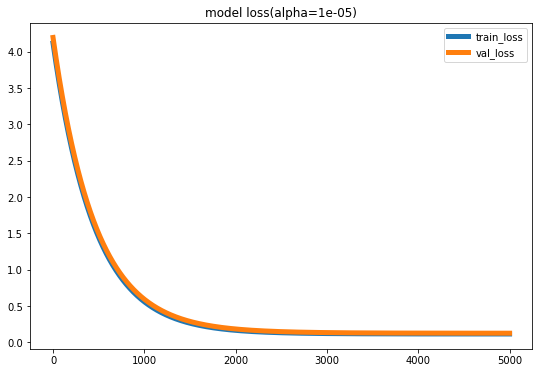

In [1250]:
fig,ax = plt.subplots(1,1,figsize=(9,6))
ax.set_title("model loss(alpha={})".format(lr2.lr))
ax.plot(np.arange(len(lr2.loss)),lr2.loss,label="train_loss",linewidth=5)
ax.plot(np.arange(len(lr2.val_loss)),lr2.val_loss,label="val_loss",linewidth=5)
ax.legend()
plt.show()

ほぼ同じグラフを示しているが平均2乗誤差はバイアス項なしだと数値がやや高くなってしまう。

In [1231]:
#特徴量を変えて検証
feature = ["YearBuilt","YearRemodAdd","TotRmsAbvGrd","OverallQual","GrLivArea"]
error = np.empty(15).reshape(3,5)
for i in range(5):
    df_x2 = df[feature[i]].apply(np.log)
    df_y2 = df.SalePrice.apply(np.log)
    x_train,x_test,y_train,y_test = train_test_split(np.array(df_x2),np.array(df_y2),train_size = 0.8,random_state=1)
    lr_bias = ScratchLinearRegression(verbose=False)
    lr_no_bias = ScratchLinearRegression(no_bias=True,verbose=False)
    lr_bias.fit(x_train,y_train,x_test,y_test)
    lr_no_bias.fit(x_train,y_train,x_test,y_test)
    pred_bias = lr_bias.predict(x_test)
    pred_no_bias = lr_no_bias.predict(x_test)
    print("特徴量{}で検証".format(feature[i]))
    print("平均2乗誤差（バイアス項あり）:{}".format(MSE(pred_bias,y_test)))
    print("平均2乗誤差（バイアス項なし）:{}\n".format(MSE(pred_no_bias,y_test)))
    error[0,i] = MSE(pred_bias,y_test)
    error[1,i] = MSE(pred_no_bias,y_test)
    error[2,i] = error[1,i] - error[0,i]
error_data = pd.DataFrame(error,index = ["バイアス項あり","バイアス項なし","バイアス項なし-バイアス項あり"],\
                          columns=feature)
display(error_data)


特徴量YearBuiltで検証
平均2乗誤差（バイアス項あり）:0.19297368159643535
平均2乗誤差（バイアス項なし）:0.21552039154113237

特徴量YearRemodAddで検証
平均2乗誤差（バイアス項あり）:0.19242351433492297
平均2乗誤差（バイアス項なし）:0.21463270680795823

特徴量TotRmsAbvGrdで検証
平均2乗誤差（バイアス項あり）:54.57282545413062
平均2乗誤差（バイアス項なし）:74.10714234731812

特徴量OverallQualで検証
平均2乗誤差（バイアス項あり）:56.733572719407846
平均2乗誤差（バイアス項なし）:76.91847367560985

特徴量GrLivAreaで検証
平均2乗誤差（バイアス項あり）:0.47885036086385524
平均2乗誤差（バイアス項なし）:0.5773639072127514



,YearBuilt,YearRemodAdd,TotRmsAbvGrd,OverallQual,GrLivArea
バイアス項あり,0.192974,0.192424,54.572825,56.733573,0.478850
バイアス項なし,0.215520,0.214633,74.107142,76.918474,0.577364
バイアス項なし-バイアス項あり,0.022547,0.022209,19.534317,20.184901,0.098514


In [1104]:
#特徴量の数を変えて検証
feature = ["YearBuilt","YearRemodAdd","TotRmsAbvGrd","OverallQual","GrLivArea"]
error = np.empty(15).reshape(3,5)
for i in range(5):
    df_x2 = df[features_list[:i+1]].apply(np.log)
    df_y2 = df.SalePrice.apply(np.log)
    x_train,x_test,y_train,y_test = train_test_split(np.array(df_x2),np.array(df_y2),train_size = 0.8,random_state=1)
    lr_bias = ScratchLinearRegression(verbose=False)
    lr_no_bias = ScratchLinearRegression(no_bias=True,verbose=False)
    lr_bias.fit(x_train,y_train,x_test,y_test)
    lr_no_bias.fit(x_train,y_train,x_test,y_test)
    pred_bias = lr_bias.predict(x_test)
    pred_no_bias = lr_no_bias.predict(x_test)
    print("特徴量{}つで検証".format(i+1))
    print("平均2乗誤差（バイアス項あり）:{}".format(MSE(pred_bias,y_test)))
    print("平均2乗誤差（バイアス項なし）:{}\n".format(MSE(pred_no_bias,y_test)))
    error[0,i] = MSE(pred_bias,y_test)
    error[1,i] = MSE(pred_no_bias,y_test)
    error[2,i] = error[1,i] - error[0,i]
error_data = pd.DataFrame(error,index = ["バイアス項あり","バイアス項なし","バイアス項なし-バイアス項あり"],\
                          columns=[1,2,3,4,5])
display(error_data)


特徴量1つで検証
平均2乗誤差（バイアス項あり）:0.19297368159643535
平均2乗誤差（バイアス項なし）:0.21552039154113237

特徴量2つで検証
平均2乗誤差（バイアス項あり）:0.17730262535794644
平均2乗誤差（バイアス項なし）:0.1770466231893288

特徴量3つで検証
平均2乗誤差（バイアス項あり）:0.22795858950818657
平均2乗誤差（バイアス項なし）:0.22965983336528772

特徴量4つで検証
平均2乗誤差（バイアス項あり）:0.3224436413425831
平均2乗誤差（バイアス項なし）:0.3275902196263335

特徴量5つで検証
平均2乗誤差（バイアス項あり）:0.39907164504286086
平均2乗誤差（バイアス項なし）:0.4144673283050833



,1,2,3,4,5
バイアス項あり,0.192974,0.177303,0.227959,0.322444,0.399072
バイアス項なし,0.215520,0.177047,0.229660,0.327590,0.414467
バイアス項なし-バイアス項あり,0.022547,-0.000256,0.001701,0.005147,0.015396


># [考察]
バイアス項が無い場合、バイアス項の分を他のθを変えることで残差を減らそうとするためθの各値が適切な値から遠のいてしまい、モデルの予測精度が下がる可能性がある。特徴量を変えながら平均2乗誤差を比べてみると、どの場合もバイアス項ありの方が精度が高い。  
特徴量によっては学習率などを変更しないと平均2乗誤差がかなり大きくなってしまうため複数の特徴量を用いる方が誤差は小さくなると感じたので、２つ目の検証では特徴量の数を変えながら指標値を比較した。全体的に平均2乗誤差が小さいため差はかなり小さかったがほとんどの場合はバイアス項ありの方が精度が高い結果が出た。

># 【問題9】（アドバンス課題）特徴量の多次元化
特徴量の二乗や三乗を入力に利用すると学習結果がどう変化するか検証してください。

In [1238]:
df_y = df.SalePrice
first_df = df[features_list].apply(np.log)
df_y_f = df_y.apply(np.log)
square_df = (df[features_list]**2).apply(np.log)
df_y_s = (df_y**2).apply(np.log)
third_df = (df[features_list]**3).apply(np.log)
df_y_t = (df_y**3).apply(np.log)
x_train1,x_test1,y_train1,y_test1 = train_test_split(np.array(first_df),np.array(df_y_f),train_size = 0.8,random_state=1)
x_train2,x_test2,y_train2,y_test2 = train_test_split(np.array(square_df),np.array(df_y_s),train_size = 0.8,random_state=1)
x_train3,x_test3,y_train3,y_test3 = train_test_split(np.array(third_df),np.array(df_y_t),train_size = 0.8,random_state=1)
lr_f = ScratchLinearRegression(verbose=False)
lr_s = ScratchLinearRegression(verbose=False)
lr_t = ScratchLinearRegression(verbose=False)
lr_f.fit(x_train1,y_train1)
lr_s.fit(x_train2,y_train2)
lr_t.fit(x_train3,y_train3)
pred_f = lr_f.predict(x_test1)
pred_s = lr_s.predict(x_test2)
pred_t = lr_t.predict(x_test3)
print("特徴量を分析した平均２乗誤差:{}".format(MSE(pred_f,y_test1)))
print("特徴量の２乗を分析した平均２乗誤差:{}".format(MSE(pred_s,y_test2)))
print("特徴量の3乗を分析した平均２乗誤差:{}".format(MSE(pred_t,y_test3)))

特徴量を分析した平均２乗誤差:0.24084845167707664
特徴量の２乗を分析した平均２乗誤差:0.9804099100241516
特徴量の3乗を分析した平均２乗誤差:2.2239677646743963


２乗、３乗していくと値が大きくなるためデータにばらつきが出て精度が下がっていくことがわかる。

># 【問題10】（アドバンス課題）更新式の導出
最急降下法の更新式は以下でした。この式が導出される過程を説明してください。

>$
\theta_j := \theta_j - \alpha \frac{1}{m} \sum_{i=1}^{m}[(h_\theta(x^{(i)}) - y^{(i)} )x_{j}^{(i)}]
$

>以下の式から説明をはじめることができます。

>$
\theta_j := \theta_j - \frac{\partial}{\partial \theta_j}J(\theta) \\
$

>目的関数（損失関数） $J(\theta)$ は次の式です。

>$
J(\theta)=  \frac{1 }{ 2m}  \sum_{i=1}^{m} (h_\theta(x^{(i)})-y^{(i)})^2.
$

$
\theta_j 
$

$
:= \theta_j - \frac{\partial}{\partial \theta_j}J(\theta) \\
$

$
= \theta_j - \frac{\partial}{\partial \theta_j} * \frac{1 }{ 2m}  \sum_{i=1}^{m} (h_\theta(x^{(i)})-y^{(i)})^2
$

$
= \theta_j - \frac{1 }{ 2m}\sum_{i=1}^{m}\frac{\partial}{\partial \theta_j}(h_\theta(x^{(i)})-y^{(i)})^2
$

$
=\theta_j - \frac{1 }{ m}\sum_{i=1}^{m}(h_\theta(x^{(i)})-y^{(i)})\frac{\partial (h_\theta(x^{(i)})}{\partial \theta_j}
$

$
=\theta_j - \frac{1 }{ m}\sum_{i=1}^{m}(h_\theta(x^{(i)})-y^{(i)})\frac{\partial (h_\theta(x^{(i)})}{\partial \theta_j}
$

$
=\theta_j - \alpha\frac{1 }{ m}\sum_{i=1}^{m}(h_\theta(x^{(i)})-y^{(i)})x_{j}^{(i)}
$

># おまけ
イテレーション数を大きくするのとcross validationを用いて、正確にはどの程度の精度が出るのかを検証する

In [1253]:
%%time
K = 4
value = 0
kf_price = KFold(n_splits=K,random_state=1)
df_x = df[features_list].apply(np.log)
df_y = df.SalePrice.apply(np.log)

for train_index,test_index in kf_price.split(df):
    x_train,x_test = np.array(df_x.iloc[train_index]),np.array(df_x.iloc[test_index])
    y_train,y_test = np.array(df_y.iloc[train_index]),np.array(df_y.iloc[test_index])
    #線形回帰
    lr = ScratchLinearRegression(num_iter=10000,verbose=False)
    lr.fit(x_train,y_train)
    #予測
    y_pred = lr.predict(x_test)
    value += mean_squared_error(y_pred,y_test)
print("{}回の平均".format(K))
print("平均２乗誤差:{}".format(value/K))

4回の平均
平均２乗誤差:0.0723331246933054
CPU times: user 1min 33s, sys: 687 ms, total: 1min 34s
Wall time: 1min 34s
